# Weekly Report: 4 August 2020

### Summary:
Reviewed training data.  
Lnphi diverges at low b_mix values (b_mix < 0.001).  
b_i/b_mix may replace b_i as an independent variable.  
Principle Component Analysis (PCA) did not show areas where lnphi is discontinuous with respect to the independent variables.  
Standardized training data (mean=0, stdev=1) did not improve training.  

### Discussion:
Lnphi diverges to positive infinity as b_mix tends to zero:
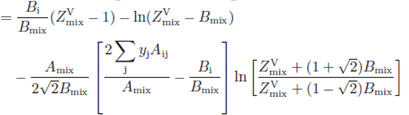
From Gupta and Singh, NN are better at interpolating than extrapolating. Therefore, the training set must span the domain of use in reservoir simulation. Improbable instances in training data can be removed to help training.  
Training data scaling is important depending on the activation function. For Leaky ReLU, positive values for attributes (indep vars) and labels (target value lnphi) may be required.  
Principle Component Analysis (PCA) did not clearly show where lnphi is discontinuous. Reducing independent variables from 4 to 2 still captured 98% of the variance. The figure below is lnphi vs X_1, X_2. The axes were found by PCA. 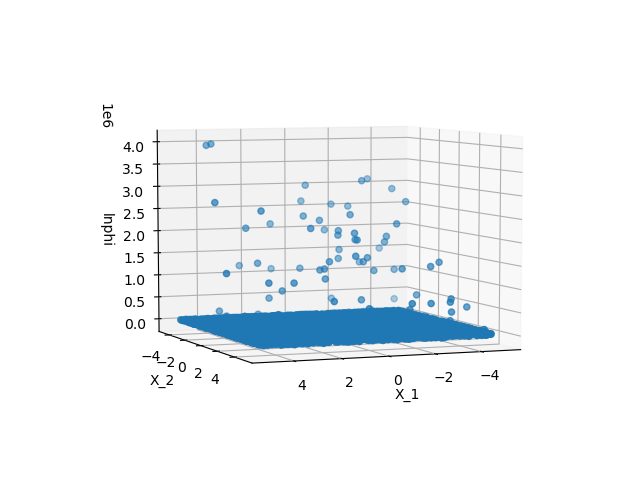

### What's next:
Train with normalized lnphi values (min=0, max=1). Previously, only the independent variables were normalized. The Leaky ReLU may perform better with normalized label as well.  
Continue data exploration.  
Consider replacing b_i with b_i / b_mix as an attribute.

Explore training data: lnphi generated from linearly spaced a_mix, b_mix, b_i and sum_xjAij. Ranges of variables taken from a run of case study 1 of Jose's thesis.



In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


In [2]:
%%time
csv_path = r'E:\Datasets\data_const_T_20200716-230921.csv'
d = pd.read_csv(csv_path, delimiter=',', names=['a_mix', 'b_mix',
                                            'b_i', 'sum', 'lnphi'])

Wall time: 1min 6s


Plot dataset vs a_mix, b_mix.
Interactive plot cleary shows divergent lnphi at low b_mix values.

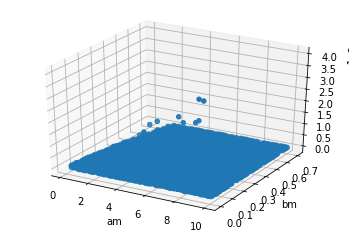

In [3]:
# Random subset of data. Can't plot entire data at once.
X = d.drop(['lnphi'], axis=1)
X_partial, X_test, y_train_partial, y_train_test = train_test_split(
    X, d[['lnphi']], test_size=0.9999, random_state=42
)
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection='3d')
ax2.scatter(X_partial.iloc[:,0], X_partial.iloc[:,1], y_train_partial, marker='o')
ax2.set_xlabel('am')
ax2.set_ylabel('bm')
plt.show()

Zoom in on Lnphi at divergence (b_mix < 0.05).
Figure shows that a low value of b_mix (b_mix <= 0.001) makes lnphi diverge. Low b_mix correspond to low Pr/Tr behavior.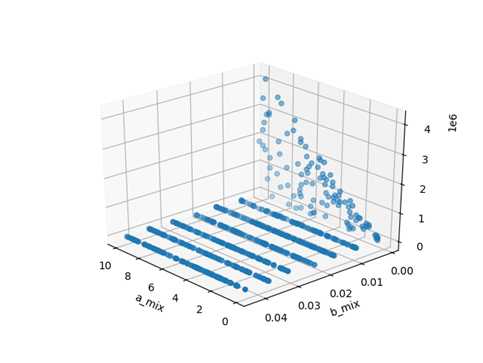


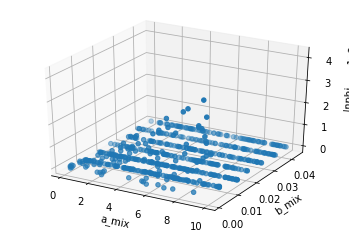

In [4]:
# Lnphi vs a_mix, b_mix at divergence (b_mix < 0.05). Case study min b_mix was 0.006.
X2 = d[d['b_mix'] < 0.05].drop(['lnphi'], axis=1)
y2 = d[d['b_mix'] < 0.05].loc[:,'lnphi']

X_partial, X_test, y_train_partial, y_train_test = train_test_split(
    X2, y2, test_size=0.9999, random_state=42
)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection='3d')
ax3.scatter(X_partial.iloc[:,0], X_partial.iloc[:,1], y_train_partial, marker='o')
ax3.set_xlabel('a_mix')
ax3.set_ylabel('b_mix')
ax3.set_zlabel('lnphi')
plt.show()

Truncation of dataset to lnphi in [-50,50] helped ANN training. However, the mean percent absolute error (MAPE) was still around 8%. 0.01% is desired.
Plot lnphi vs independent variables.

In [5]:
# Limit lnphi values to [-50,50]
desc = d.drop(d.loc[(d.loc[:,'lnphi'] < -50) | (d.loc[:,'lnphi'] > 50)].index)

In [6]:
# Select random subset of data set. Becase can't plot entire dataset at once.
X = desc.drop(['lnphi'], axis=1)
y = desc.loc[:,'lnphi']
X_partial, X_test, y_train_partial, y_train_test = train_test_split(
    X, y, test_size=0.9999, random_state=42
)


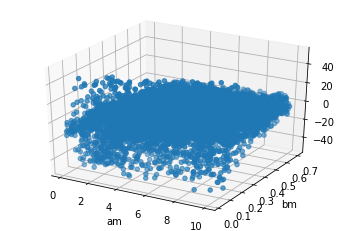

In [7]:
# Lnphi vs a_mix, b_mix
%matplotlib inline
fig4 = plt.figure()
ax4 = fig4.add_subplot(111, projection='3d')
ax4.scatter(X_partial.iloc[:,0], X_partial.iloc[:,1], y_train_partial, marker='o')
ax4.set_xlabel('am')
ax4.set_ylabel('bm')
plt.show()

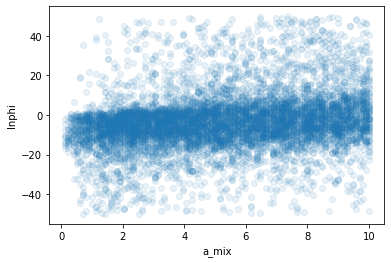

In [8]:
# Lnphi vs a_mix.

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_partial.iloc[:,0], y_train_partial, alpha=0.1)
ax.set_xlabel('a_mix')
ax.set_ylabel('lnphi')
plt.show()

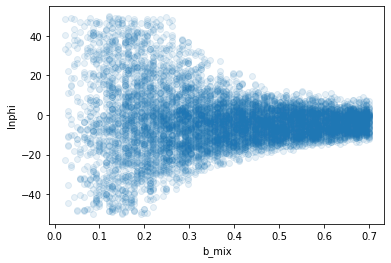

In [9]:
# Lnphi vs b_mix
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_partial.iloc[:,1], y_train_partial, alpha=0.1)
ax.set_xlabel('b_mix')
ax.set_ylabel('lnphi')
plt.show()

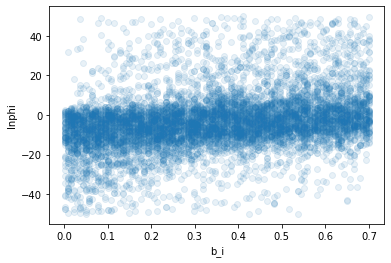

In [10]:
# Lnphi vs b_i
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_partial.iloc[:,2], y_train_partial, alpha=0.1)
ax.set_xlabel('b_i')
ax.set_ylabel('lnphi')
plt.show()

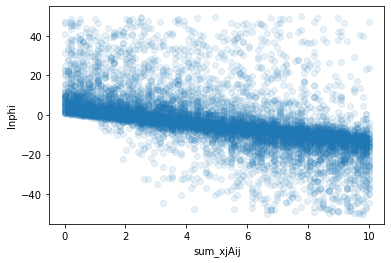

In [11]:
# Lnphi vs sum_xjAij
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_partial.iloc[:,3], y_train_partial, alpha=0.1)
ax.set_xlabel('sum_xjAij')
ax.set_ylabel('lnphi')
plt.show()

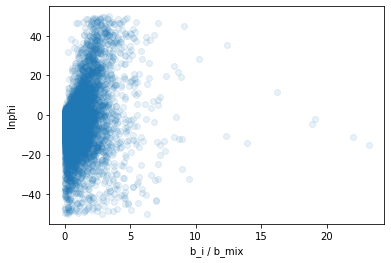

In [12]:
# Lnphi vs b_i/b_mix
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_partial.iloc[:,2]/X_partial.iloc[:,1], y_train_partial, alpha=0.1)
ax.set_xlabel('b_i / b_mix')
ax.set_ylabel('lnphi')
plt.show()

Potentially replace b_i with b_i/b_mix? It looks like this may have better correlation. Can check correlation with lnphi.

Standardization of dataset to zero mean and unit variance did not improve substantially training.
From the notes of Singh and Gupta, the activation function in NN is sensitive to input data scaling. The Leaky ReLU function may perform better with normalized inputs and outputs, meaning with values in [0,1].

Check what the smallest Bm possible. Check smallest B_i from hydrogen
Keep current model parameters, improve later if it works.
Plot and find exactly the reason for discontinuity. Plot lnphi where it is discontinuous.
Verify if discontinuity causes poor training. Give result from hypothesis: Try training with a_mix, b_mix where only a single root. Assume the discontinuity arises from multiple roots.

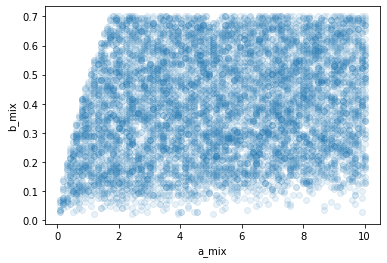

In [13]:
# b_mix vs a_mix
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_partial.iloc[:,0],X_partial.iloc[:,1], alpha=0.1)
ax.set_xlabel('a_mix')
ax.set_ylabel('b_mix')
plt.show()

This is lnphi vs (a_mix, b_mix). No truncation of lnphi values.
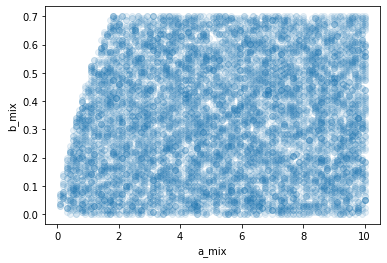